<center> <h1><b>Estrategia: R-cuadrado</b> </h1></center>

Esta estrategia usa el modelo de Fama-French de cuatro factores.

\begin{equation}
    r_i−r_f = β_0+β_1(r_m−r_f)+β_2 SMB+β_3 HML + \epsilon
\end{equation}

Donde:

* $r_i$: Es el retorno del activo a.
* $r_f$: Es la tasa libre de riesgo.
* $r_i − r_f$: Es el retorno en exceso del activo.
* $r_m − r_f$: Es la prima de riesgo de mercado.
* SMB: Es el factor tamaño o small minus big market cap, este factor nos dice que las empresas de menor capitalización de mercado tienen un rendimiento superior que las empresas de mayor capitalización.
* HML: Es el factor valor o high minus low price to book, este factor nos dice que las empresas con un alto ratio price to book tienen un rendimiento superior que las empresas de bajo ratio price to book.
* $\beta_j (j>0)$: Paramétros a ajustar mediante métodos de regresión.
* $\beta_0 = \alpha_i$: interceptos hallados mediante métodos de regresión.

In [1]:
# # Correr esta celda una sola vez
# !pip install --upgrade version_information
# !pip install pandas_datareader
# !pip install yfinance

In [2]:
import pandas_datareader.data as reader    # Para traer la data directamente de la página de Fama-French
import pandas as pd
import numpy as np
import os
from datetime import date
import yfinance as yf
import version_information

### Nombre de archivos importantes pagina Fama-French 

**3 factor famma french**

- Mensual: 'F-F_Research_Data_Factors'
- Semanal: 'F-F_Research_Data_Factors_weekly'
- Diaria: 'F-F_Research_Data_Factors_daily'

**Momentum factor**

- Mensual: 'F-F_Momentum_Factor'
- Diaria: 'F-F_Momentum_Factor_daily'

### 1. Traer la data (mensual, semanal,...) 
    
Se van a traer tres distintos dataframes: el primero contiene los tres factores originales del modelo de Fama-French, el segundo contiene el cuarto factor (Momento) y el cuarto dataFrame contiene los precios de cierre de los activos que componen el portafolio.

In [3]:
end = date.today()
start = date(end.year - 5, end.month, end.day)

# Tres factores principales de fama-french
ff_df = reader.DataReader('F-F_Research_Data_Factors', 'famafrench', start, end)[0]

# factor de momento
ff_MOM_df = reader.DataReader('F-F_Momentum_Factor', 'famafrench', start, end)[0]

# acciones
# el mismo que la data ade fama-french
s = ff_df.index[-1]
end1 = date(s.year, s.month, 29)
# un mes atras respecto a la data de fama-french
start1 = date(end.year - 5, end.month-1, 1)

tickers = ["NTRS", "O", "SBUX", "SWK", "COF", "M", "ECL", "EXC", "HRB"]
precios = yf.download(tickers, start=start1, end=end1, interval="1mo")["Close"]
precios.index = pd.to_datetime(precios.index, format="%Y%m").to_period("M")

[*********************100%***********************]  9 of 9 completed


In [4]:
precios.head()

,COF,ECL,EXC,HRB,M,NTRS,O,SBUX,SWK
Date,,,,,,,,,
2018-05,94.000000,142.610001,29.522112,27.450001,34.910000,102.519997,51.647285,56.669998,139.240005
2018-06,91.900002,140.330002,30.385164,22.780001,37.430000,102.889999,52.122093,48.849998,132.809998
2018-07,94.320000,140.699997,30.313837,25.160000,39.730000,109.220001,54.040699,52.389999,149.470001
2018-08,99.089996,150.479996,31.176889,27.059999,36.549999,107.459999,56.753876,53.450001,140.529999
2018-09,94.930000,156.779999,31.141228,25.750000,34.730000,102.129997,55.125969,56.840000,146.440002


In [5]:
precios.shape

(60, 9)

In [6]:
ff_df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-06,0.48,1.15,-2.33,0.14
2018-07,3.19,-2.23,0.47,0.16
2018-08,3.44,1.13,-3.98,0.16
2018-09,0.06,-2.28,-1.69,0.15
2018-10,-7.68,-4.77,3.44,0.19


In [7]:
ff_df.shape

(59, 4)

In [8]:
ff_MOM_df.tail()

,Mom
Date,
2022-12,4.52
2023-01,-15.98
2023-02,0.21
2023-03,-2.50
2023-04,1.56


In [9]:
ff_MOM_df.shape

(59, 1)

<h3> 2. Unir Fama-French DataFrames

In [10]:
ff_4f = ff_df.merge(ff_MOM_df, on=ff_df.index)
ff_4f.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom'] 
ff_4f.set_index(["Date"], inplace=True)
ff_4f.head()

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2018-06,0.48,1.15,-2.33,0.14,-2.35
2018-07,3.19,-2.23,0.47,0.16,-1.41
2018-08,3.44,1.13,-3.98,0.16,5.29
2018-09,0.06,-2.28,-1.69,0.15,0.04
2018-10,-7.68,-4.77,3.44,0.19,-1.99


<h3> 3. Retornos

Al calular los retornos, la primera fila va quedar sin datos que por lo cual que se elimina. Esta es la razón por la que se descargo la data de los precios de cierre con una fecha demás respecto al dataframe de Fama-French. Luego, ajustamos los retornos de los precios con la columna "RF" de Fama-French, para asi obtener el retorno en exceso para cada activo.

In [11]:
retornos = precios.pct_change()
retornos.dropna(inplace=True)
retornos.head()

,COF,ECL,EXC,HRB,M,NTRS,O,SBUX,SWK
Date,,,,,,,,,
2018-06,-0.022340,-0.015988,0.029234,-0.170128,0.072186,0.003609,0.009193,-0.137992,-0.046179
2018-07,0.026333,0.002637,-0.002347,0.104478,0.061448,0.061522,0.036810,0.072467,0.125442
2018-08,0.050572,0.069510,0.028471,0.075517,-0.080040,-0.016114,0.050206,0.020233,-0.059811
2018-09,-0.041982,0.041866,-0.001144,-0.048411,-0.049795,-0.049600,-0.028684,0.063424,0.042055
2018-10,-0.059307,-0.023153,0.003436,0.030680,-0.012669,-0.078919,0.059413,0.025158,-0.204316


In [12]:
ret_rf = pd.DataFrame(retornos.values - ff_4f[["RF"]].values, columns= retornos.columns, index=retornos.index)
ret_rf.head()

,COF,ECL,EXC,HRB,M,NTRS,O,SBUX,SWK
Date,,,,,,,,,
2018-06,-0.162340,-0.155988,-0.110766,-0.310128,-0.067814,-0.136391,-0.130807,-0.277992,-0.186179
2018-07,-0.133667,-0.157363,-0.162347,-0.055522,-0.098552,-0.098478,-0.123190,-0.087533,-0.034558
2018-08,-0.109428,-0.090490,-0.131529,-0.084483,-0.240040,-0.176114,-0.109794,-0.139767,-0.219811
2018-09,-0.191982,-0.108134,-0.151144,-0.198411,-0.199795,-0.199600,-0.178684,-0.086576,-0.107945
2018-10,-0.249307,-0.213153,-0.186564,-0.159320,-0.202669,-0.268919,-0.130587,-0.164842,-0.394316


<Axes: title={'center': 'Retornos de los activos en el portafolio'}, xlabel='Date', ylabel='Retornos %'>

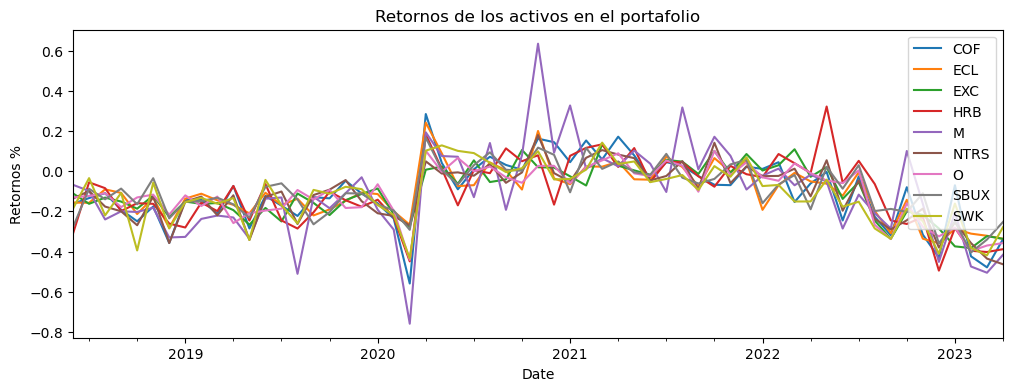

In [34]:
ret_rf.plot(figsize=(12, 4), title="Retornos de los activos en el portafolio", ylabel="Retornos %")

<h3> 4. Implementar modelo

Primero se reescribe la ecuación a ajustar en forma matricial (debido a que es mucho más eficiente programar operaciones matriciales, que en su lugar, por ejemplo ejecutar todo mediante un ciclo for para através de cada activo en el portafolio). Para ello, se suponen $N$ activos y que el retorno en exceso $R_i, i=1,2,...,N$ viene dado por:

$$R_i = \alpha_i + \sum_{k=1}^{4} β_{i,k} F_k + \epsilon_i$$

En forma matricial para todos los activos, se tiene la siguiente forma:

$$R = \alpha + BF + \epsilon $$

\begin{equation}
    R =  
    \begin{bmatrix}
        R_1 \\
        R_2 \\
        \vdots\\
        R_N 
    \end{bmatrix},\quad
    \alpha =  
    \begin{bmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \vdots\\
        \alpha_N 
    \end{bmatrix}, \quad
    B =
    \begin{bmatrix}
        \beta_{1,1} & \beta_{1,2} & \beta_{1,3} & \beta_{1,4}\\
        \beta_{2,1} & \beta_{2,2} & \beta_{2,3} & \beta_{2,4}\\
        \vdots      & \vdots      & \vdots & \vdots     \\
        \beta_{N,1} & \beta_{N,2} & \beta_{N,3} &\beta_{N,4}
    \end{bmatrix}, \quad
    F =  
    \begin{bmatrix}
        r_m - r_f \\
        SMB       \\
        HML       \\
        Mom 
    \end{bmatrix}, \quad
    \epsilon =  
    \begin{bmatrix}
        \epsilon_1 \\
        \epsilon_2 \\
        \vdots\\
        \epsilon_N 
    \end{bmatrix}.
\end{equation}

In [13]:
from sklearn.linear_model import LinearRegression
from scipy import stats

In [14]:
# usando sklearn
X = ff_4f[['Mkt-RF', 'SMB', 'HML','Mom']].values
y = ret_rf.values

lr = LinearRegression()
lr.fit(X, y)
B = np.matrix(lr.coef_)
alpha = lr.intercept_

# Coefficient of determination
r_sq = lr.score(X, y)

In [15]:
r_sq

0.36744435882420623

In [16]:
B = pd.DataFrame(B, index=precios.columns, columns=['Mkt-RF', 'SMB', 'HML','Mom'])
alpha = pd.DataFrame(alpha, index=precios.columns, columns=["Alpha"])
regresion_df = pd.concat([alpha, B], axis=1)

In [17]:
regresion_df

,Alpha,Mkt-RF,SMB,HML,Mom
COF,-0.110593,0.015301,0.016775,0.015109,0.003955
ECL,-0.114141,0.012791,0.008994,0.004215,0.006167
EXC,-0.108703,0.009449,0.004577,0.010269,0.008529
HRB,-0.105120,0.009611,0.011266,0.015862,0.007350
M,-0.112604,0.019065,0.028613,0.023112,0.008626
NTRS,-0.120063,0.012586,0.007980,0.010917,0.003597
O,-0.112165,0.011198,0.006192,0.008549,0.006954
SBUX,-0.104529,0.011832,0.004862,0.005235,0.003872
SWK,-0.123231,0.014415,0.009123,0.010087,0.003387


### 4.1 Calculo R cuadrado

Ahora se calculan los $R^{2}$ para los valores $\alpha$ estimados. Este se calculara a partir de las siguientes cantidades:

1. Promedio de el exceso de los retornos $\overline{R}(t).$
2. Suma de cuadrados $SS_{tot}.$
3. Suma de cuadrados residual $SS_{res}.$
4. $R^{2}$ de la regresión.

1. Comenzando por el promedio de los retornos (siguiendo la siguiente definición)
$$ \overline{R}(t) = \frac{1}{N} \sum_{i=1}^{N} R_i(t)$$

In [18]:
ret_rf.head()

,COF,ECL,EXC,HRB,M,NTRS,O,SBUX,SWK
Date,,,,,,,,,
2018-06,-0.162340,-0.155988,-0.110766,-0.310128,-0.067814,-0.136391,-0.130807,-0.277992,-0.186179
2018-07,-0.133667,-0.157363,-0.162347,-0.055522,-0.098552,-0.098478,-0.123190,-0.087533,-0.034558
2018-08,-0.109428,-0.090490,-0.131529,-0.084483,-0.240040,-0.176114,-0.109794,-0.139767,-0.219811
2018-09,-0.191982,-0.108134,-0.151144,-0.198411,-0.199795,-0.199600,-0.178684,-0.086576,-0.107945
2018-10,-0.249307,-0.213153,-0.186564,-0.159320,-0.202669,-0.268919,-0.130587,-0.164842,-0.394316


In [21]:
# retorno medio
ret_rf.mean(axis=0)

COF    -0.104835
ECL    -0.106689
EXC    -0.104233
HRB    -0.103133
M      -0.108331
NTRS   -0.113631
O      -0.106212
SBUX   -0.096928
SWK    -0.115372
dtype: float64

2. Ahora, el calculo de la suma de cuadrados $SS_{tot}$:

$$SS_{tot} = \sum_{i=1}^{N} \big(R_i(t) - \overline{R}(t)\big)^2$$

3. Luego, se calcula la suma de los cuadrados 

$$SS_{res} = \sum_{i=1}^{N} \epsilon_{i}^{2}(t)$$

4. Y, finalmente el termino $R^{2}$ como sigue:

\begin{equation}
    R^{2} = 1 - \frac{SS_{res}}{SS_{tot}}
\end{equation}

In [20]:
%load_ext version_information

%version_information numpy, scipy, pandas, sklearn

Software versions
Python 3.10.9 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.10.0
OS Windows 10 10.0.22621 SP0
numpy 1.23.5
scipy 1.10.0
pandas 1.5.3
sklearn 1.2.1
Tue Jun 06 11:03:09 2023 Hora est. Pacífico, Sudamérica